In [2]:
# svm_oasis2.py

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, RocCurveDisplay)
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
df = pd.read_excel("oasis.xlsx") 
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1986.550000,0.696106,0.883440
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004.479526,0.681062,0.875539
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678.290000,0.736336,1.045710
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1737.620000,0.713402,1.010000
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1697.911134,0.701236,1.033623


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    float64
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(6), int64(4), object(5)
memory usage: 43.8+ KB


In [6]:
# Drop non-numeric IDs
df = df.drop(columns=["Subject ID", "MRI ID"])

In [7]:
df['Group'].value_counts()

Group
Nondemented    190
Demented       146
Converted       37
Name: count, dtype: int64

In [8]:
# Encode categorical columns
for col in ["Group", "M/F", "Hand"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

In [9]:
# Handle missing values
df = df.fillna(df.median())

In [10]:
# Features and target
X = df.drop(columns=["Group"])   # Group is the target (0=Nondemented, 1=Demented)
y = df["Group"]


In [11]:
y.value_counts()

Group
2    190
1    146
0     37
Name: count, dtype: int64

In [12]:
# ---------- Train-Test Split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [13]:

# ---------- Scale ----------
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [14]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression

# ---------- Logistic Regression with GridSearch ----------
param_grid = {
    "C": [0.1, 1, 10],       # Inverse of regularization strength
    "penalty": ["l2"],       # L2 regularization (default)
    "solver": ["lbfgs"]      # Suitable for multinomial logistic regression
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(LogisticRegression(max_iter=1000, multi_class="ovr"), param_grid, scoring="roc_auc_ovr", cv=cv, n_jobs=-1)
grid.fit(X_train_s, y_train)

best = grid.best_estimator_
print("Best Params:", grid.best_params_)


Best Params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


d:\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [15]:
# ---------- Evaluation ----------
y_pred = best.predict(X_test_s)
y_prob = best.predict_proba(X_test_s)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

print("\nMetrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1:", f1_score(y_test, y_pred, average='weighted'))
# print("ROC AUC:", roc_auc_score(y_test, y_prob, average='weighted', multi_class='ovr'))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.94      1.00      0.97        29
           2       0.88      1.00      0.94        38

    accuracy                           0.91        75
   macro avg       0.94      0.71      0.71        75
weighted avg       0.92      0.91      0.87        75

Confusion Matrix:
 [[ 1  2  5]
 [ 0 29  0]
 [ 0  0 38]]

Metrics:
Accuracy: 0.9066666666666666
Precision: 0.9161390347586897
Recall: 0.9066666666666666
F1: 0.8728724279835391


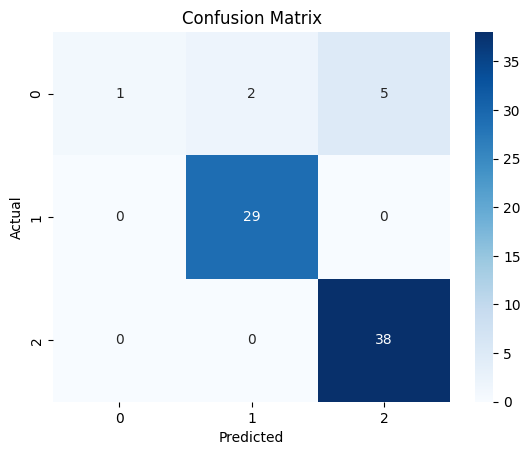

In [16]:
# ---------- Plots ----------
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

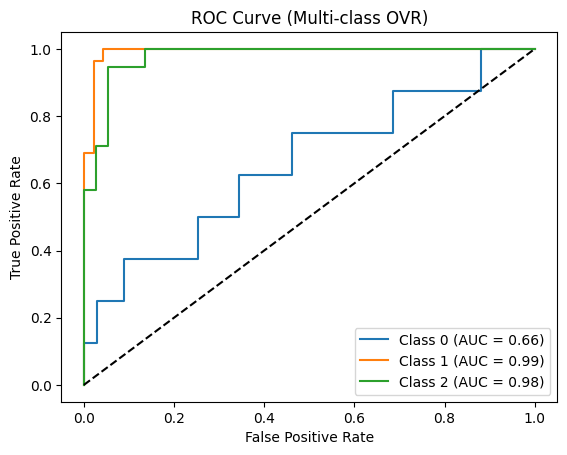

Average ROC AUC (ovr): 0.875249775592024


In [17]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

classes = np.unique(y_test)

if len(classes) == 2:
    # ----- Binary Classification -----
    y_prob = best.predict_proba(X_test_s)[:, 1]   # probability of positive class
    auc_score = roc_auc_score(y_test, y_prob)
    print("ROC AUC (binary):", auc_score)

    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title("ROC Curve (Binary)")
    plt.show()

else:
    # ----- Multi-Class (One-vs-Rest) -----
    y_test_bin = label_binarize(y_test, classes=classes)
    y_prob = best.decision_function(X_test_s)  # shape: (n_samples, n_classes)

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure()
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multi-class OVR)")
    plt.legend(loc="lower right")
    plt.show()

    print("Average ROC AUC (ovr):", roc_auc_score(y_test_bin, y_prob, multi_class="ovr"))
